# Tutorial 7: A Deep Dive into the SpikeProcessor

This tutorial focuses on the `SpikeProcessor`, designed specifically for handling neural spike train data. Spike data is often represented as a list of timestamps, which requires a different processing approach than continuous signals.

**Goal:**
1.  Understand the expected input format for spike data.
2.  Manually use the `SpikeProcessor` to see how it converts spike times into a 3D tensor.
3.  Explain the key parameters: `window_size`, `step_size`, and `max_spikes_per_window`.

## 1. Imports

In [1]:
import torch
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 2. Generating Correlated Spike Data

The library expects spike data to be a **list of numpy arrays**. Each array represents a neuron and contains its spike timestamps.

We'll generate data where population `Y` is driven by `X` with a 20ms delay. By setting the `jitter` to a small value, we create a strong correlation that should result in a significant, non-zero mutual information.

In [2]:
x_spike_data, y_spike_data = nmi.datasets.generate_correlated_spike_trains(
    n_neurons=5, 
    duration=100.0, 
    delay=0.02,     # 20 ms delay
    jitter=0.001    # Very low jitter for a strong correlation
)

print(f"Data is a list of {len(x_spike_data)} neurons.")
print(f"Spike times for first neuron in X: {x_spike_data[0][:10]}...")

Data is a list of 5 neurons.
Spike times for first neuron in X: [0.41286607 0.57237908 0.86681403 1.17277757 1.76304385 2.14249917
 2.35069841 2.63862927 2.91370895 2.95281258]...


## 3. Manual Processing with `SpikeProcessor`

The `SpikeProcessor` converts the list of spike times into a 3D tensor of shape `(n_samples, n_channels, n_features)`.

Key parameters:
- `window_size`: The duration of the time window (e.g., 0.1 seconds).
- `step_size`: The time to slide the window forward for each new sample.
- `n_seconds`: The total duration of the data to analyze. This is useful for analyzing a subset of a long recording.
- `max_spikes_per_window`: This sets the maximum number of spikes to keep from any window. If a window has more spikes, they are truncated; if it has fewer, the feature vector is padded with zeros.

In [3]:
# Initialize the processor to analyze the first 20 seconds of the data
processor = nmi.data.SpikeProcessor(
    window_size=0.1,  # 100 ms window
    step_size=0.01,   # 10 ms step
    n_seconds=20,     # Analyze the first 20 seconds
    max_spikes_per_window=10 # Keep at most 10 spikes per window
)

# Process the data
x_processed = processor.process(x_spike_data)

print(f"Processed data shape: {x_processed.shape}")

Processed data shape: torch.Size([1991, 5, 10])


The output shape `(1991, 5, 10)` makes sense:
- **~1990 samples**: The number of samples is determined by `(duration - window_size) / step_size`. For a 20s duration, a 0.1s window, and a 0.01s step, we expect `(20 - 0.1) / 0.01 = 1990` windows. The exact number can vary slightly based on floating point precision and the precise timing of the first spike.
- **5 channels**: The number of neurons is preserved.
- **10 features**: Each sample contains the times of up to 10 spikes relative to the start of the window.

### Visualizing a Spike Window

A spike raster plot can help visualize this process. The red shaded region represents a single time window that becomes one sample in our processed tensor.

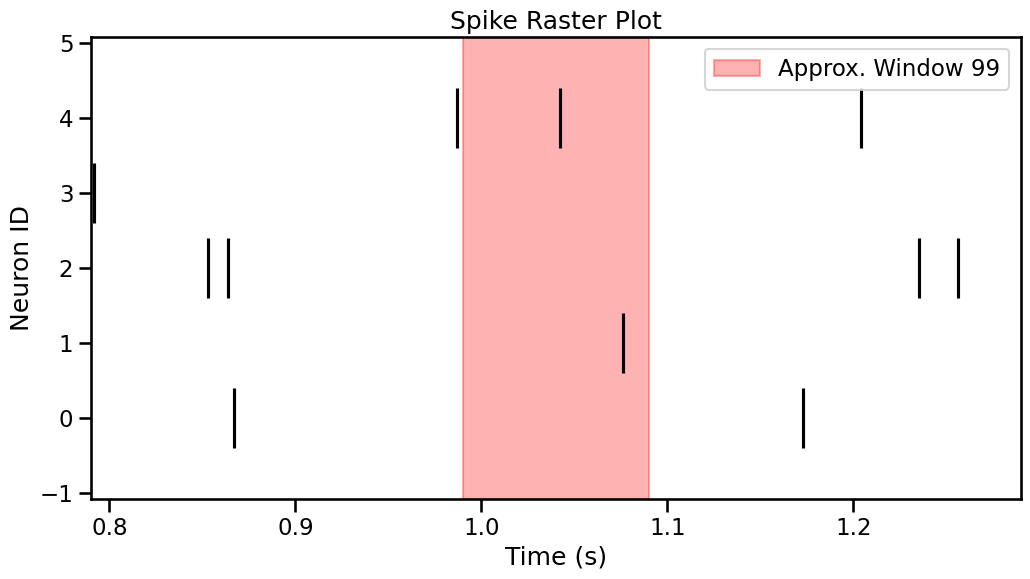

Contents of processed tensor for window 99 (channel 0):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [4]:
window_idx = 99
window_size = processor.window_size
step_size = processor.step_size

start_time = window_idx * step_size # Note: this is an approximation, real start depends on first spike
end_time = start_time + window_size

fig, ax = plt.subplots(figsize=(12, 6))

ax.eventplot(x_spike_data, color='black', linelengths=0.8)
ax.set_title('Spike Raster Plot')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.axvspan(start_time, end_time, color='red', alpha=0.3, label=f'Approx. Window {window_idx}')
ax.legend()
ax.set_xlim(start_time - window_size*2, end_time + window_size*2)

plt.show()

print(f"Contents of processed tensor for window {window_idx} (channel 0):")
print(x_processed[window_idx, 0, :])

## 4. Simplified Workflow and MI Estimation

Now we use the simplified `nmi.run` workflow. Because we generated strongly correlated data, we expect the MI estimate to be significantly greater than zero.

In [5]:
base_params = {
    'n_epochs': 20, 'learning_rate': 1e-3, 'batch_size': 128,
    'patience': 3, 'embedding_dim': 8, 'hidden_dim': 32, 'n_layers': 1
}

results = nmi.run(
    x_data=x_spike_data,
    y_data=y_spike_data,
    mode='estimate',
    processor_type='spike',
    # Use a window large enough to capture the 20ms delay
    processor_params={'window_size': 0.05, 'step_size': 0.01},
    base_params=base_params,
    random_seed=42,
    verbose=False
)

print(f"\nMI Estimate from automated pipeline: {results.mi_estimate:.3f} bits")

2025-10-04 20:01:20 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 20:01:28 - neural_mi - INFO - Parameter sweep finished.

MI Estimate from automated pipeline: 0.316 bits


## 5. Conclusion

This tutorial explained how to format spike train data and how the `SpikeProcessor` turns it into a tensor suitable for MI estimation. We also confirmed that with strongly correlated spike data, the library correctly estimates a significant, non-zero mutual information.